<a href="https://colab.research.google.com/github/williancribeiro/Desafio-Form/blob/master/IAFinanceira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import os
os.environ['TZ'] = 'GMT'
from datetime import datetime, timedelta

import math
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error
!pip install yfinance --upgrade --no-cache-dir

# Inicio do código

In [23]:
acao, dt_inicio, dt_final = "BBAS3.SA", "1996-09-06", "2023-11-18"

[*********************100%%**********************]  1 of 1 completed


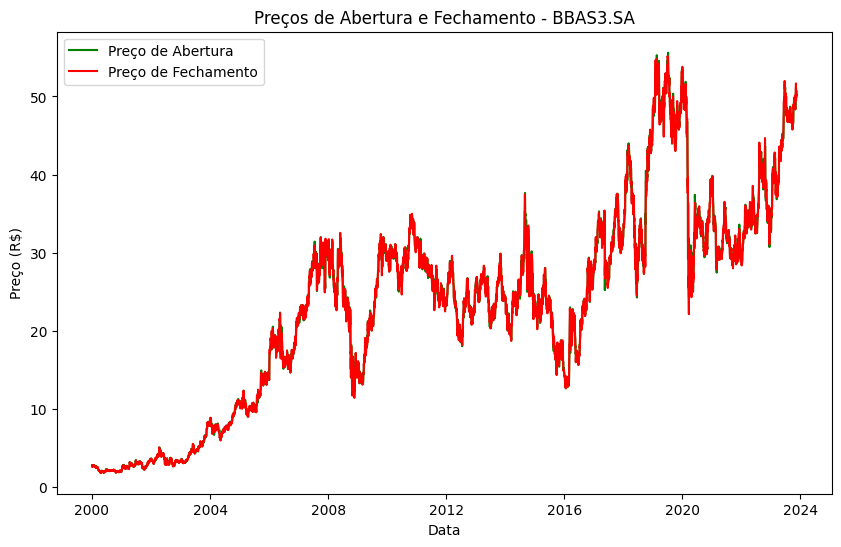

In [35]:
infoacao = yf.download(acao, start=dt_inicio, end=dt_final)

preco_abertura = infoacao['Open']
preco_fechamento = infoacao['Close']

plt.figure(figsize=(10, 6))  # Ajusta o tamanho do gráfico
plt.plot(preco_abertura, label='Preço de Abertura', color='green')
plt.plot(preco_fechamento, label='Preço de Fechamento', color='red')

plt.title(f"Preços de Abertura e Fechamento - {acao}")
plt.xlabel("Data")
plt.ylabel("Preço (R$)")
plt.legend()

plt.show()

In [37]:
preco_abertura_fechamento = infoacao[["Open", "Close"]]

print(preco_abertura_fechamento)

                 Open      Close
Date                            
2000-01-03   2.800000   2.733333
2000-01-04   2.733333   2.603333
2000-01-05   2.600000   2.630000
2000-01-06   2.630000   2.666666
2000-01-07   2.666666   2.606666
...               ...        ...
2023-11-10  49.770000  50.240002
2023-11-13  50.099998  50.049999
2023-11-14  50.180000  50.290001
2023-11-16  50.299999  50.279999
2023-11-17  50.279999  50.660000

[5907 rows x 2 columns]


In [38]:
cota = infoacao['Close'].to_numpy().reshape(-1, 1)

print(cota)

[[ 2.73333311]
 [ 2.603333  ]
 [ 2.63000011]
 ...
 [50.29000092]
 [50.27999878]
 [50.65999985]]


In [41]:
fator_divisao = 0.90

tamanho_dados_treinamento = int(len(cota) * fator_divisao )

print(tamanho_dados_treinamento)

5316


In [101]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento

escalar = MinMaxScaler(feature_range=(0, 1))

tamanho_dados_treinamento = int(len(cotacao) * 0.90)

dado_treino = cotacao[:tamanho_dados_treinamento, :]
dados_teste = cotacao[tamanho_dados_treinamento:, :]

dado_0_1_treino = escalar.fit_transform(dado_treino)
dado_0_1_teste = escalar.transform(dados_teste)

dados_0_1_final = np.concatenate([dado_0_1_treino.ravel(), dado_0_1_teste.ravel()])

dados_0_1_final = dados_0_1_final.reshape(-1, 1)

In [72]:
def criar_dados(dados_0_1_final, dias_dados, qtd_treino=120, offset=0):

    treino_x = []
    treino_y = []

    for i in range(qtd_treino, dias_dados):
        seq_x = dados_0_1_final[i - qtd_treino: i, 0]
        valor_y = dados_0_1_final[i, 0]
        treino_x.append(seq_x)
        treino_y.append(valor_y)

    return np.array(treino_x), np.array(treino_y)



In [77]:
dados_para_treinamento = dados_entre_0_e_1[:tamanho_dados_treinamento, :]

# Dados que serão usados para gerar o resultado
treino_x = []
# Cotação que aconteceu de fato
treino_y = []

# Criar sequências para treinamento
for i in range(60, len(dados_para_treinamento)):
    seq_ultimos_dias = dados_para_treinamento[i - 15:i, 0]
    cotacao_atual = dados_para_treinamento[i, 0]

    treino_x.append(seq_ultimos_dias)
    treino_y.append(cotacao_atual)

In [78]:
#transformando as listas em arrays e dando reshape 3d

treino_x, treino_y = np.array(treino_x), np.array(treino_y)

treino_x = treino_x.reshape(treino_x.shape[0], treino_x.shape[1], 1)

print (treino_x)

[[[0.01187203]
  [0.01337165]
  [0.00962259]
  ...
  [0.00449888]
  [0.00499875]
  [0.00474881]]

 [[0.01337165]
  [0.00962259]
  [0.00906023]
  ...
  [0.00499875]
  [0.00474881]
  [0.00493626]]

 [[0.00962259]
  [0.00906023]
  [0.00937266]
  ...
  [0.00474881]
  [0.00493626]
  [0.00356161]]

 ...

 [[0.62921772]
  [0.63334164]
  [0.63109223]
  ...
  [0.57354412]
  [0.56792054]
  [0.56154713]]

 [[0.63334164]
  [0.63109223]
  [0.63577855]
  ...
  [0.56792054]
  [0.56154713]
  [0.56810796]]

 [[0.63109223]
  [0.63577855]
  [0.61984507]
  ...
  [0.56154713]
  [0.56810796]
  [0.56435892]]]


In [79]:
#modelo

NUMERO_NEURONIOS_LSTM = 50
NUMERO_NEURONIOS_DENSE = 25
NUMERO_NEURONIOS_SAIDA = 1

modelo = Sequential()

modelo.add(LSTM(NUMERO_NEURONIOS_LSTM, return_sequences=True, input_shape=(treino_x.shape[1], 1)))

modelo.add(LSTM(NUMERO_NEURONIOS_LSTM, return_sequences=False))

modelo.add(Dense(NUMERO_NEURONIOS_DENSE))

modelo.add(Dense(NUMERO_NEURONIOS_SAIDA))

print(treino_x.shape[1])

15


In [81]:
#copilando o modelo

modelo.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae", "mse"])

In [87]:
#treinar o modelo

modelo.fit(treino_x, treino_y, batch_size=16, epochs=50, validation_split=0.2)

Epoch 1/50
263/263 [==============================] - 8s 29ms/step - loss: 1.0630e-04 - mae: 0.0072 - mse: 1.0630e-04 - val_loss: 9.1617e-04 - val_mae: 0.0239 - val_mse: 9.1617e-04
Epoch 2/50
263/263 [==============================] - 8s 29ms/step - loss: 1.1460e-04 - mae: 0.0076 - mse: 1.1460e-04 - val_loss: 4.8131e-04 - val_mae: 0.0158 - val_mse: 4.8131e-04
Epoch 3/50
263/263 [==============================] - 6s 23ms/step - loss: 1.0904e-04 - mae: 0.0073 - mse: 1.0904e-04 - val_loss: 5.3159e-04 - val_mae: 0.0167 - val_mse: 5.3159e-04
Epoch 4/50
263/263 [==============================] - 8s 30ms/step - loss: 1.0438e-04 - mae: 0.0071 - mse: 1.0438e-04 - val_loss: 5.5546e-04 - val_mae: 0.0172 - val_mse: 5.5546e-04
Epoch 5/50
263/263 [==============================] - 6s 23ms/step - loss: 1.0111e-04 - mae: 0.0069 - mse: 1.0111e-04 - val_loss: 6.9786e-04 - val_mae: 0.0199 - val_mse: 6.9786e-04
Epoch 6/50
263/263 [==============================] - 7s 28ms/step - loss: 1.0508e-04 - mae: 0.

In [98]:
# Ajuste dos dados de teste para manter apenas os últimos 15 dias
dados_teste = dados_0_1_final[tamanho_dados_treinamento - 15:, 0]

teste_x = np.array([dados_teste[i - 15:i] for i in range(15, len(dados_teste))])

teste_y = cotacao[tamanho_dados_treinamento:, 0]

teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [99]:
#reshape
if teste_x.shape[-1] != 1:
    teste_x = np.expand_dims(teste_x, axis=-1)

In [103]:
# Previsões do modelo e inversão da escala em uma única linha
predicoes = escalar.inverse_transform(modelo.predict(teste_x))

# Exibir as previsões
print(predicoes)

19/19 [==============================] - 0s 14ms/step
[[31.343824]
 [31.765144]
 [31.699636]
 [32.47373 ]
 [32.334576]
 [32.506493]
 [32.0204  ]
 [31.624563]
 [31.414408]
 [31.993242]
 [32.319756]
 [31.808735]
 [31.62    ]
 [32.1378  ]
 [32.299335]
 [32.743263]
 [32.22077 ]
 [31.451502]
 [31.90952 ]
 [31.777218]
 [31.281162]
 [30.72683 ]
 [31.692081]
 [31.429361]
 [30.573278]
 [30.287327]
 [29.674852]
 [29.449602]
 [29.424522]
 [29.30571 ]
 [29.439531]
 [29.637703]
 [29.663214]
 [29.91997 ]
 [30.535698]
 [30.41567 ]
 [29.95365 ]
 [30.427593]
 [30.161097]
 [30.329023]
 [30.372   ]
 [29.099394]
 [29.040016]
 [29.631277]
 [28.361105]
 [28.846096]
 [28.989412]
 [29.60454 ]
 [29.178724]
 [28.92058 ]
 [29.42121 ]
 [28.893404]
 [27.922215]
 [28.680391]
 [29.388828]
 [29.403778]
 [29.133478]
 [29.79641 ]
 [29.193386]
 [29.330442]
 [28.836903]
 [29.49357 ]
 [29.154995]
 [30.522512]
 [30.5749  ]
 [30.187037]
 [30.834276]
 [30.620764]
 [30.632336]
 [30.496836]
 [31.470068]
 [32.102566]
 [30.47657

In [107]:
#pegando o erro médio quadrático RMSE (Root Mean Squared Error)

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

0.6127847164818881

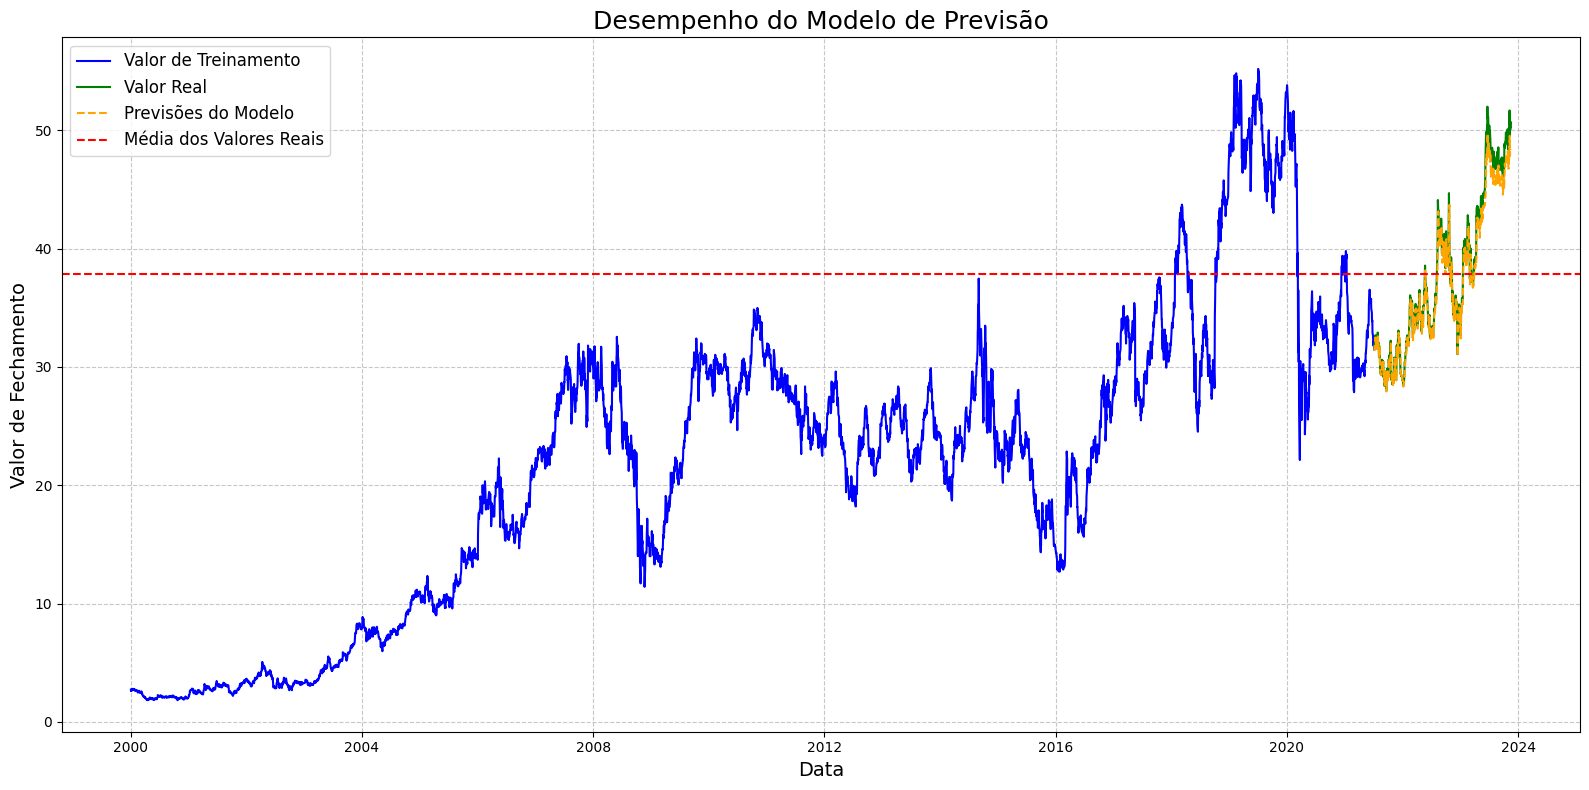

In [115]:
#criando o grafico do modelo

def plotar_desempenho_modelo(treinamento, df_teste, predicoes):
    plt.figure(figsize=(16, 8))
    plt.title('Desempenho do Modelo de Previsão', fontsize=18)
    plt.xlabel('Data', fontsize=14)
    plt.ylabel('Valor de Fechamento', fontsize=14)

    plt.plot(treinamento['Close'], label='Valor de Treinamento', linestyle='-', color='blue')
    plt.plot(df_teste['Close'], label='Valor Real', linestyle='-', color='green')
    plt.plot(df_teste['predicoes'], label='Previsões do Modelo', linestyle='--', color='orange')

    # Adicionando uma linha para representar a média dos valores reais
    plt.axhline(y=df_teste['Close'].mean(), color='r', linestyle='--', label='Média dos Valores Reais')

    plt.legend(loc='upper left', prop={'size': 12})
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Uso da função
plotar_desempenho_modelo(treinamento, df_teste, predicoes)

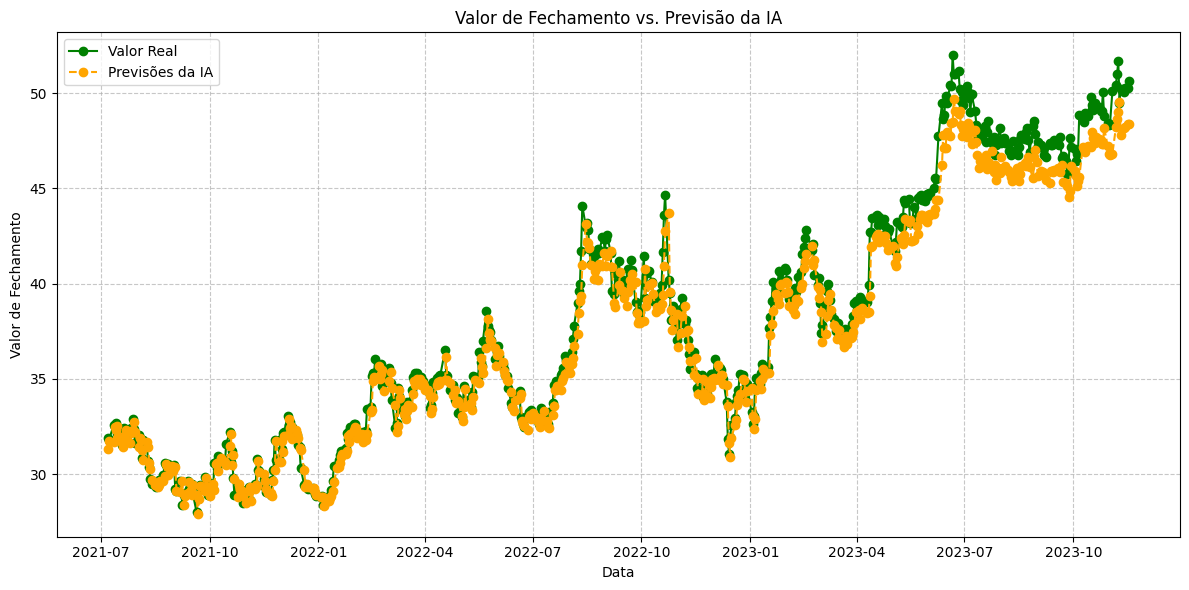

,Close,predicoes
Date,,
2021-07-07,31.879999,31.343824
2021-07-08,31.790001,31.765144
2021-07-12,32.599998,31.699636
2021-07-13,32.459999,32.473728
2021-07-14,32.680000,32.334576
...,...,...
2023-11-10,50.240002,47.813408
2023-11-13,50.049999,48.176151
2023-11-14,50.290001,48.206902


In [118]:
#fechamento vs previsão

df_teste.sort_index(inplace=True)

# Plotagem do gráfico de valor de fechamento vs previsão da IA
plt.figure(figsize=(12, 6))
plt.plot(df_teste['Close'], label='Valor Real', linestyle='-', marker='o', color='green')
plt.plot(df_teste['predicoes'], label='Previsões da IA', linestyle='--', marker='o', color='orange')

plt.title('Valor de Fechamento vs. Previsão da IA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


df_teste.sort_index()

df_teste

In [121]:
def calcular_metricas(df):
    # Calcular variação percentual
    df['variacao_percentual_acao'] = df['Close'].pct_change()
    df['variacao_percentual_modelo'] = df['predicoes'].pct_change()

    # Remover NaNs
    df.dropna(inplace=True)

    # Verificar se a variação percentual é maior ou menor que zero
    df['var_acao_maior_menor_que_zero'] = df['variacao_percentual_acao'] > 0
    df['var_modelo_maior_menor_que_zero'] = df['variacao_percentual_modelo'] > 0

    # Verificar se o modelo acertou a direção da variação
    df['acertou_o_lado'] = df['var_acao_maior_menor_que_zero'] == df['var_modelo_maior_menor_que_zero']

    # Calcular variação percentual absoluta
    df['variacao_percentual_acao_abs'] = df['variacao_percentual_acao'].abs()

    return df

# Uso da função
df_teste = calcular_metricas(df_teste)

df_teste

<ipython-input-121-4d066d9ba405>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['variacao_percentual_acao'] = df['Close'].pct_change()
<ipython-input-121-4d066d9ba405>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['variacao_percentual_modelo'] = df['predicoes'].pct_change()
<ipython-input-121-4d066d9ba405>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,Close,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2021-07-13,32.459999,32.473728,-0.004294,0.024420,False,True,False,0.004294
2021-07-14,32.680000,32.334576,0.006778,-0.004285,True,False,False,0.006778
2021-07-15,32.180000,32.506493,-0.015300,0.005317,False,True,False,0.015300
2021-07-16,31.790001,32.020401,-0.012119,-0.014954,False,False,True,0.012119
2021-07-19,31.549999,31.624563,-0.007550,-0.012362,False,False,True,0.007550
...,...,...,...,...,...,...,...,...
2023-11-10,50.240002,47.813408,0.014745,-0.034522,True,False,False,0.014745
2023-11-13,50.049999,48.176151,-0.003782,0.007587,False,True,False,0.003782
2023-11-14,50.290001,48.206902,0.004795,0.000638,True,True,True,0.004795


In [124]:
def calcular_metricas_desempenho(df):
    acertos_positivos = df['acertou_o_lado'].sum()
    total_registros = len(df['acertou_o_lado'])

    acertos_de_lado_positivo = acertos_positivos / total_registros
    errou_lado = 1 - acertos_de_lado_positivo

    media_lucro = df.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

    exp_mat_lucro = acertos_de_lado_positivo * media_lucro[1] - media_lucro[0] * errou_lado

    ganho_sobre_perda = media_lucro[1] / media_lucro[0]

    return acertos_de_lado_positivo, errou_lado, media_lucro, ganho_sobre_perda, exp_mat_lucro

# Uso da função
(acertos_positivos, errou_lado, media_lucro, ganho_sobre_perda, exp_mat_lucro) = calcular_metricas_desempenho(df_teste)

print("Média de Lucro:")
print(media_lucro)
print("\nGanho sobre Perda:")
print(ganho_sobre_perda)
print("\nAcertos de Lado Positivo:")
print(acertos_positivos)
print("\nExpectativa Matemática de Lucro (%):")
print(exp_mat_lucro * 100)

Média de Lucro:
acertou_o_lado
False    0.014128
True     0.013880
Name: variacao_percentual_acao_abs, dtype: float64

Ganho sobre Perda:
0.9824370985101908

Acertos de Lado Positivo:
0.4914965986394558

Expectativa Matemática de Lucro (%):
-0.03622328679128515


In [132]:
def obter_cotacoes_e_prever(acao, escalar, modelo):
    data_hoje = datetime.now()

    if data_hoje.hour > 18:
        final = data_hoje
    else:
        final = data_hoje - timedelta(days=1)

    inicial = datetime.now() - timedelta(days=252)

    print('Passou')

    cotacoes = yf.download(acao, start=inicial, end=final)
    qtd_ultimos_dias = cotacoes['Close'].iloc[-120:].values.reshape(-1, 1)

    dias_escalados = escalar.transform(qtd_ultimos_dias)

    teste_x = np.array([dias_escalados])
    teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

    previsao_de_preco = modelo.predict(teste_x)
    previsao_de_preco = escalar.inverse_transform(previsao_de_preco)

    return previsao_de_preco

# Exemplo de uso
acao_exemplo = "BBAS3.SA"
previsao = obter_cotacoes_e_prever(acao_exemplo, escalar, modelo)
print(previsao)

Passou
[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 50ms/step
[[49.251125]]
